# Trabajo de Dataset con datos reales

- Los datos fueron extraidos de la página "Kaggle", específicamente en el enlace: "https://www.kaggle.com/datasets/sufya6/e-commerce-customer-journey-click-to-conversion"

- El data set trata de un conjunto de datos sintético sobre comercio electrónico, creado para reflejar el “viaje del cliente” desde que hace un clic hasta que realiza la conversión (compra).

### importando librerias

In [33]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

### Cargando el dataset

In [34]:
df = pd.read_csv("customer_journey.csv")

## 1. Informacion general del dataset

In [35]:
print(" Informacion general del dataset")
display(df.info())

 Informacion general del dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12719 entries, 0 to 12718
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   SessionID           12719 non-null  object
 1   UserID              12719 non-null  object
 2   Timestamp           12719 non-null  object
 3   PageType            12719 non-null  object
 4   DeviceType          12719 non-null  object
 5   Country             12719 non-null  object
 6   ReferralSource      12719 non-null  object
 7   TimeOnPage_seconds  12719 non-null  int64 
 8   ItemsInCart         12719 non-null  int64 
 9   Purchased           12719 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 993.8+ KB


None

## 2. Analisis Descriptivo

In [36]:
print(" Estadisticas numericas:")
display(df.describe())

 Estadisticas numericas:


,TimeOnPage_seconds,ItemsInCart,Purchased
count,12719.000000,12719.000000,12719.000000
mean,97.427707,1.138533,0.397044
std,48.120729,1.689954,0.489304
min,15.000000,0.000000,0.000000
25%,56.000000,0.000000,0.000000
50%,98.000000,0.000000,0.000000
75%,139.000000,2.000000,1.000000
max,180.000000,5.000000,1.000000


In [37]:
print("Valores nulos por columna:")
print(df.isnull().sum()) # podemos observar que no tenemos valores nulos

Valores nulos por columna:
SessionID             0
UserID                0
Timestamp             0
PageType              0
DeviceType            0
Country               0
ReferralSource        0
TimeOnPage_seconds    0
ItemsInCart           0
Purchased             0
dtype: int64


# 3. Analisis exploratorio

### compras realizadas (0 = no | 1 = si)

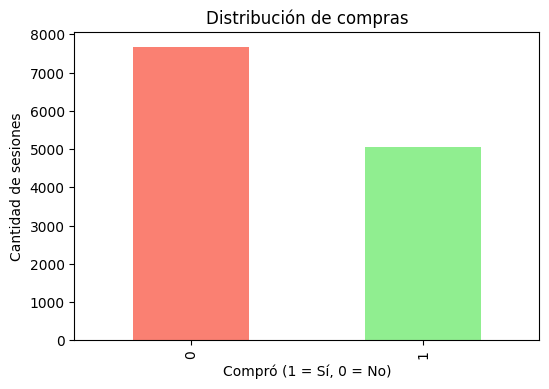

In [38]:
plt.figure(figsize=(6,4))
df["Purchased"].value_counts().plot(kind='bar', color=['salmon', 'lightgreen'])
plt.title("Distribución de compras")
plt.xlabel("Compró (1 = Sí, 0 = No)")
plt.ylabel("Cantidad de sesiones")
plt.show()

### Dispositivos más usados

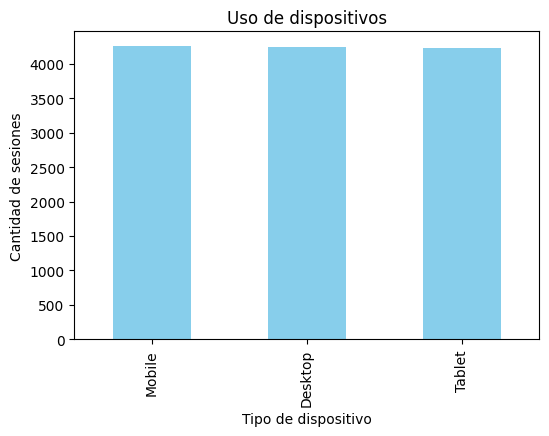

In [39]:
plt.figure(figsize=(6,4))
df["DeviceType"].value_counts().plot(kind='bar', color='skyblue')
plt.title("Uso de dispositivos")
plt.xlabel("Tipo de dispositivo")
plt.ylabel("Cantidad de sesiones")
plt.show()

### Fuentes de trafico

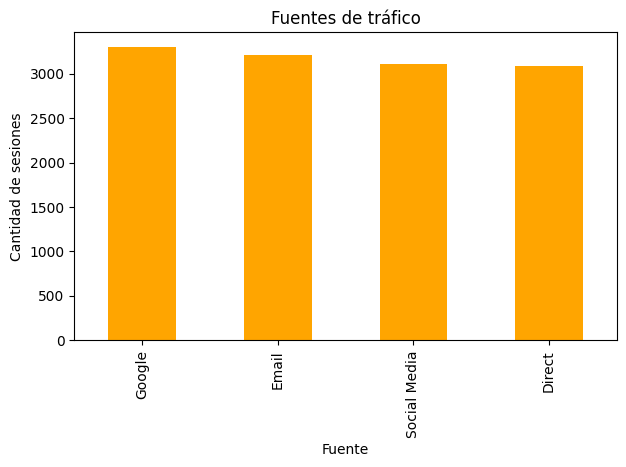

In [40]:
plt.figure(figsize=(7,4))
df["ReferralSource"].value_counts().plot(kind='bar', color='orange')
plt.title("Fuentes de tráfico")
plt.xlabel("Fuente")
plt.ylabel("Cantidad de sesiones")
plt.show()

### Tiempo promedio en la página según tipo de página

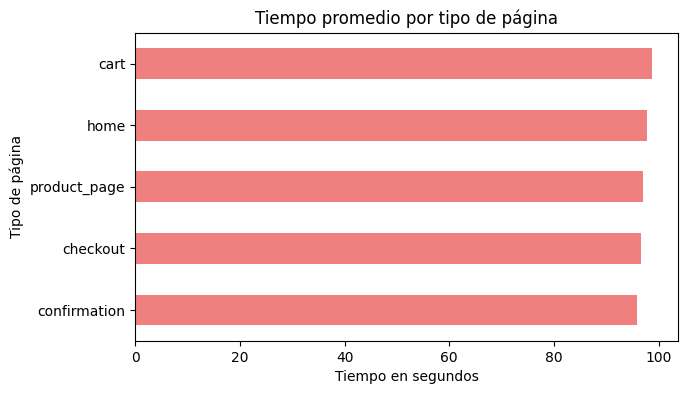

In [41]:
avg_time = df.groupby("PageType")["TimeOnPage_seconds"].mean().sort_values()
plt.figure(figsize=(7,4))
avg_time.plot(kind='barh', color='lightcoral')
plt.title("Tiempo promedio por tipo de página")
plt.xlabel("Tiempo en segundos")
plt.ylabel("Tipo de página")
plt.show()


### Países con más sesiones

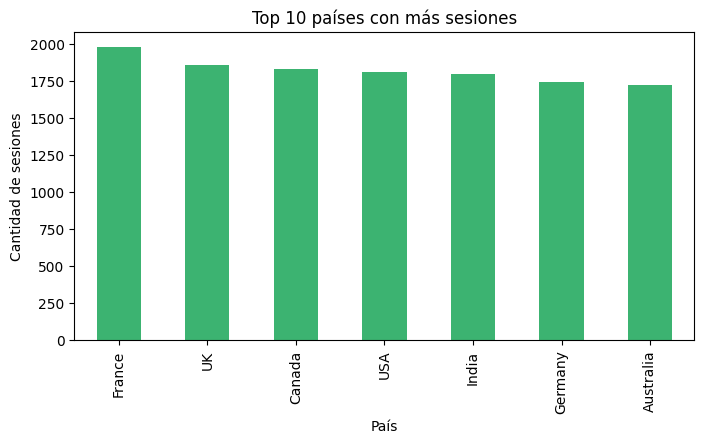

In [42]:
plt.figure(figsize=(8,4))
df["Country"].value_counts().head(10).plot(kind='bar', color='mediumseagreen')
plt.title("Top 10 países con más sesiones")
plt.xlabel("País")
plt.ylabel("Cantidad de sesiones")
plt.show()

### Relación entre ítems en carrito y compra

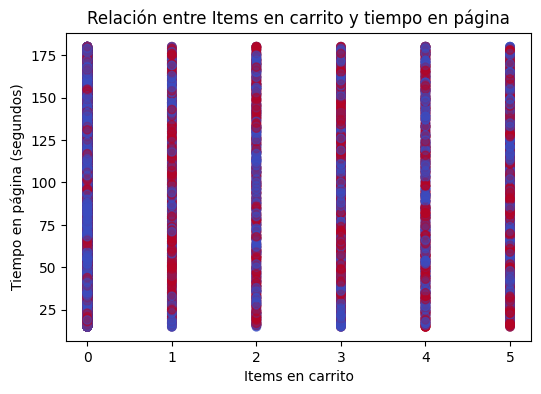

In [43]:
plt.figure(figsize=(6,4))
plt.scatter(df["ItemsInCart"], df["TimeOnPage_seconds"], alpha=0.5, c=df["Purchased"], cmap="coolwarm")
plt.title("Relación entre Items en carrito y tiempo en página")
plt.xlabel("Items en carrito")
plt.ylabel("Tiempo en página (segundos)")
plt.show()

### Visualizacion geografica

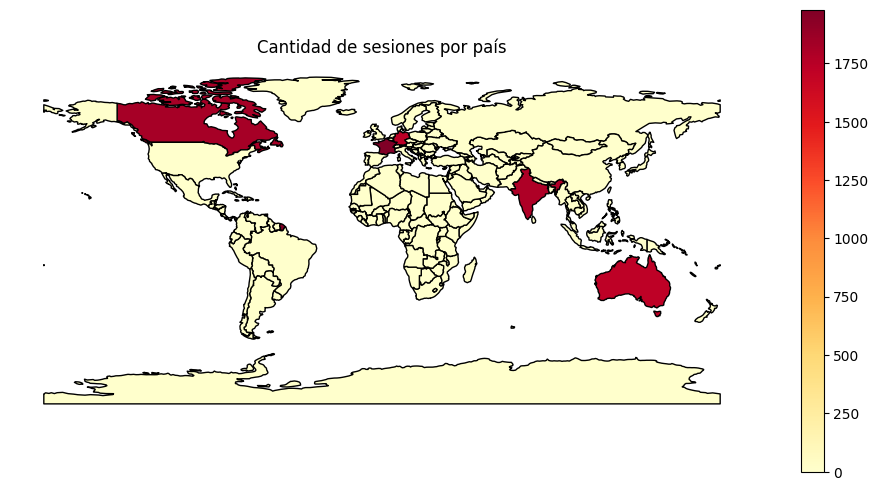

In [47]:
# Descargar y leer el shapefile de Natural Earth (110m)
import urllib.request, zipfile, io, tempfile, os

url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
resp = urllib.request.urlopen(url)
z = zipfile.ZipFile(io.BytesIO(resp.read()))

tmpdir = tempfile.mkdtemp()
z.extractall(tmpdir)

# buscar el .shp extraído y leerlo
shp = next(f for f in os.listdir(tmpdir) if f.endswith(".shp"))
world = gpd.read_file(os.path.join(tmpdir, shp))

# Normalizar/asegurar que exista la columna 'name' en el GeoDataFrame
# Natural Earth puede usar columnas como 'NAME', 'ADMIN' o 'name' según la versión; buscamos la más adecuada
possible = [c for c in world.columns if c.lower() in ['name','admin','name_long','name_en','admin0_name']]
if possible:
    world = world.rename(columns={possible[0]: 'name'})
else:
    # fallback: usar la primera columna de tipo object si existe
    strcols = [c for c in world.columns if world[c].dtype == object]
    if strcols:
        world = world.rename(columns={strcols[0]: 'name'})
    else:
        world['name'] = None

# Preparar conteo de sesiones por país a partir del DataFrame 'df'
country_counts = df['Country'].value_counts().reset_index()
country_counts.columns = ['name', 'sessions']

# Combinar con el mapa (left join para mantener todos los polígono del mundo)
world_data = world.merge(country_counts, on='name', how='left')
# Rellenar con 0 donde no haya sesiones
world_data['sessions'] = world_data['sessions'].fillna(0)

# Graficar mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
world_data.plot(column='sessions', cmap='YlOrRd', legend=True, ax=ax, edgecolor='black', missing_kwds={'color': 'lightgrey'})
ax.set_title("Cantidad de sesiones por país")
ax.set_axis_off()
plt.show()

# 5. Observaciones finales

### Conclusiones preliminares:
- La mayoría de las sesiones no terminan en compra (Purchased = 0).
- Los dispositivos más usados son Desktop y Mobile.
- Las fuentes de tráfico principales provienen de Google y Social Media.
- El tiempo en página varía según el tipo de página (checkout, product_page, etc.).
- A mayor cantidad de ítems en el carrito, suele aumentar el tiempo en página.
- En el mapa se observa la distribución de actividad por país, destacando regiones con mayor tráfico.